# Problems with the Error

* The assumption about the error term $\epsilon$ is that it is independent and indentically distributed (i.i.d)
* That means that $var \: \epsilon= \sigma^2I$
* We also assume that the errors are normally distributed
* When those assumptions are violated (i.e., not i.i.d.), we should considered **generalized least squares (GLS)** 
* When the errors are identically distributed, but are not independent, we use **weighted least squares (WLS)**, which is a special case of *GLS*
* We can test is the observed error is much larger than our expectation as evidence off *lack of fit* 
* When errors are not normally distributed, we can use *robust regression*

## Generalized Least Squares

Sometimes errors have nonconstant variance or errors that are correlated and therefore do not assume the form $var \: \epsilon= \sigma^2I$. Suppose $var \: \epsilon= \sigma^2 \Sigma$, where $\sigma^2$ is unknown but that $\Sigma$ is known.

Consider that $\Sigma = SS^T$, where $S$ is a trianglular matrix using Choleski decomposition

<p>&nbsp;</p>
\begin{split}
y = X \beta + \epsilon \\
S^{-1}y = S^{-1} X \beta + S^{-1} \epsilon \\
y' = X' \beta + \epsilon'
\end{split}
<p>&nbsp;</p>

After  transforming, the variance in $\epsilon'$  is:

<p>&nbsp;</p>
\begin{split}
var \: \epsilon' = var(S^{-1}\epsilon) = S^{-1}(var \: \epsilon)S^{-T}= S^{-1}\sigma^2SS^TS^{-T} = \sigma^2I
\end{split}
<p>&nbsp;</p>

We can reduce GLS to OLS by transforming $y$ and $x$ with $y'=S^{-1}$ and $S^{-1}X$ respectivelly, where error $\epsilon'$ is i.i.d. By reducing the problem, we can calculate $\hat \beta$:

<p>&nbsp;</p>
\begin{split}
\hat \beta = (X^T \Sigma^{-1} X)^{-1} X^T \Sigma^{-1}y 
\end{split}
<p>&nbsp;</p>

and the variance on $\hat \beta$:

<p>&nbsp;</p>
\begin{split}
var \hat \beta = (X^T \Sigma^{-1} X)^T \sigma^2 
\end{split}
<p>&nbsp;</p>

The main probem in applying GLS in practice is that $\Sigma$ may not be known and we have to estimate it.

#### Example

* Response variable is the number of people employed (1947-1962)
* The predictors are: gross national product (GNP), population 14 years of age and more


In [1]:
library(faraway)
data(longley)

In [4]:
g = lm(Employed ~ GNP + Population, data = longley)
summary(g, cor = T)


Call:
lm(formula = Employed ~ GNP + Population, data = longley)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.80899 -0.33282 -0.02329  0.25895  1.08800 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 88.93880   13.78503   6.452 2.16e-05 ***
GNP          0.06317    0.01065   5.933 4.96e-05 ***
Population  -0.40974    0.15214  -2.693   0.0184 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5459 on 13 degrees of freedom
Multiple R-squared:  0.9791,	Adjusted R-squared:  0.9758 
F-statistic: 303.9 on 2 and 13 DF,  p-value: 1.221e-11

Correlation of Coefficients:
           (Intercept) GNP  
GNP         0.98            
Population -1.00       -0.99


In [7]:
round(cor(longley$GNP, longley$Pop), 3)

[1] 0.991

* Parameter beta is highly negatively correlated, while the variables are positively correlated
* Data collected over the tima, successive errors could be correlated. 

The simplest way to deal with such models is the autoregressive form

<p>&nbsp;</p>
\begin{split}
\epsilon_{i+1} = \varrho_i + \sigma_i 
\end{split}
<p>&nbsp;</p>

where $\sigma_i \sim N(0,\tau^2)$

In [9]:
round( cor(residuals(g)[-1], residuals(g)[-16]), 5)

[1] 0.31041

* Assuming $\Sigma_{ik} = \varrho^{i-j}$, where $\varrho = 0.31041$
* We can now construct our $\Sigma$ matrix to compute GLS estimates of $\beta$ along the SEs

In [12]:
x = model.matrix(g)

# Sigma matrix
Sigma = diag(16)
Sigma = 0.31041 ^abs(row(Sigma) - col(Sigma))
Sigma.inv = solve(Sigma)

xtxi = solve (t(x) %*% Sigma.inv %*% x)

* $\hat \beta = (X^T \Sigma^{-1} X)^{-1} X^T \Sigma^{-1}y$ 

In [14]:
# Calculating beta
(beta = solve(t(x) %*% Sigma.inv %*% x) %*% t(x) %*% Sigma.inv %*% longley$Empl)

(Intercept),94.8988949
GNP,0.0673895
Population,-0.4742741


In [15]:
res = longley$Empl - x %*% beta

In [19]:
(sig = sqrt((t(res) %*% Sigma.inv %*% res)/g$df))

0.5424432


In [20]:
round(sqrt(diag(xtxi)) * sig, 4)

Warning message in sqrt(diag(xtxi)) * sig:
“Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
”


(Intercept)         GNP  Population 
    13.9448      0.0107      0.1534

* An alternative way, is to regress $S^-1y$ on $S^-1x$

In [21]:
sm = chol(Sigma)
smi = solve(t(sm))
sx = smi %*% x
sy = smi %*% longley$Empl

In [23]:
summary(lm(sy ~ sx - 1))


Call:
lm(formula = sy ~ sx - 1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.74460 -0.34013 -0.02145  0.27667  1.07243 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
sx(Intercept) 94.89889   13.94477   6.805 1.25e-05 ***
sxGNP          0.06739    0.01070   6.296 2.76e-05 ***
sxPopulation  -0.47427    0.15339  -3.092  0.00858 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5424 on 13 degrees of freedom
Multiple R-squared:  0.9999,	Adjusted R-squared:  0.9999 
F-statistic: 4.312e+04 on 3 and 13 DF,  p-value: < 2.2e-16


* Our initial guess was that $\varrho = 0.31041$, but once once we fit out GLS model, we can reestimate it and then compute the model again with the new value until convergence

In [24]:
cor(res[-1], res[-16])

[1] 0.3564162

In [25]:
library(nlme)

In [27]:
g = gls(Employed ~ GNP + Population, correlation = corAR1 (form = ~Year), data = longley)
summary(g)

Generalized least squares fit by REML
  Model: Employed ~ GNP + Population 
  Data: longley 
       AIC      BIC    logLik
  44.66377 47.48852 -17.33188

Correlation Structure: AR(1)
 Formula: ~Year 
 Parameter estimate(s):
      Phi 
0.6441692 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 101.85813 14.198932  7.173647  0.0000
GNP           0.07207  0.010606  6.795485  0.0000
Population   -0.54851  0.154130 -3.558778  0.0035

 Correlation: 
           (Intr) GNP   
GNP         0.943       
Population -0.997 -0.966

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.5924564 -0.5447822 -0.1055401  0.3639202  1.3281898 

Residual standard error: 0.689207 
Degrees of freedom: 16 total; 13 residual

* Here $\varrho = 0.64$, let's check the CI

In [28]:
intervals(g)

Approximate 95% confidence intervals

 Coefficients:
                  lower         est.       upper
(Intercept) 71.18320461 101.85813306 132.5330615
GNP          0.04915865   0.07207088   0.0949831
Population  -0.88149053  -0.54851350  -0.2155365
attr(,"label")
[1] "Coefficients:"

 Correlation structure:
         lower      est.     upper
Phi -0.4420749 0.6441692 0.9644031
attr(,"label")
[1] "Correlation structure:"

 Residual standard error:
    lower      est.     upper 
0.2480039 0.6892070 1.9153178 

* not significant indicating no strong evidence of serial correlation

### Weighted Least Squares

* Sometimes the errors are uncorrelated, but have unequal variance where the form of the inequality is known. 
* When $\Sigma$ is diagnomal, the errors are uncorrelated but do not necessarily have equal variance
* We can adjust errors by $\Sigma = diag(1/w_1, ..., 1/w_n$ where $w_i$ is the weight so $S= diag(\sqrt{1/w_1},  ..., \sqrt{1/w_n})$

Thus we can regress $\sqrt{w_iy_i}$ by $\sqrt{w_ix_i}$ where the first column of the $X-matrix$ can be substituted by the constant $\sqrt{w_i}$

* When weights are used, residuals must be modified using $\sqrt{w_i \hat \epsilon_i}$ for diagnostics

#### Example
French presidency elections occurs in two terms. In 1981, there were 10 candidates in the first term and 2 in the second. How did the votes were transfered from the first to the second term?

* Columns are the candidates
* Row are the french regions
* EI is the registered voters
* A1, B1, and A2, and B2 are the values for the first and second terms

In [29]:
data(fpe)
head(fpe)

,EI,A,B,C,D,E,F,G,H,J,K,A2,B2,N
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Ain,260,51,64,36,23,9,5,4,4,3,3,105,114,17
Alpes,75,14,17,9,9,3,1,2,1,1,1,32,31,5
Ariege,107,27,18,13,17,2,2,2,1,1,1,57,33,6
Bouches.du.Rhone,1036,191,204,119,205,29,13,13,10,10,6,466,364,30
Charente.Maritime,367,71,76,47,37,8,34,5,4,4,2,163,142,17
Cotes.du.Nord,396,93,90,57,54,13,5,9,4,3,5,193,155,15


* We can mode the porcentage of votes transfered to the second term candidates (A1 and B2) using a regression

<p>&nbsp;</p>
\begin{split}
A_2 = \beta_AA + \beta_BB + \beta_CC + \beta_DD + \beta_EE + \beta_FF + \beta_GG + \beta_HH +  \beta_JJ + \beta_KK + \beta_NN
\end{split}
<p>&nbsp;</p>

The proportions will likely change from region to region. Thus the error will have variance in proportion to the number of voters (i.e., variance of the sum not the mean). So we can set the weights as $1/EI$

In [32]:
# not using intercept
g = lm(A2 ~ A+B+C+D+E+F+G+H+J+K+N-1, data = fpe, weights = 1/EI)
round(coef(g), 3)

A      B      C      D      E      F      G      H      J      K      N 
 1.067 -0.105  0.246  0.926  0.249  0.755  1.972 -0.566  0.612  1.211  0.529

In [34]:
# without the weights
round(lm(A2 ~ A+B+C+D+E+F+G+H+J+K+N-1, data = fpe)$coef, 3)

A      B      C      D      E      F      G      H      J      K      N 
 1.075 -0.125  0.257  0.905  0.671  0.783  2.166 -0.854  0.144  0.518  0.558

* We can truncate the coeficients that violates the maximum or minimum values for proportions (A, B, G, H, and K)


    1) A,G,k will be set to 1
    2) B and H will  be set to zero

In [37]:
round(lm(A2 ~ offset(A+G+K)+ C+D+E+F+N-1, data = fpe)$coef, 3)

C     D     E     F     N 
0.208 0.938 0.571 0.785 0.589

#### Testing for Lack of fit

* How can we test whether a model fits the data?
* If the model is correct then $\hat \sigma^2$ shold be an unbiased estimator of $\sigma^2$
* However, if we have an incomplete model (or a wrong form), then $\hat \sigma^2$ will overestimate $\sigma^2$. On the other hand, if the model is too complex and overfit the data, then $\hat \sigma^2$ will be underestimated

With that idea in mind, we can compare $\hat \sigma^2$ to $\sigma^2$. The problem is that we do not know $\sigma^2$ in most cases.

One way to estimate $\sigma^2$ by measure the repeated meareurements without any model. The 'pure error' will then be $SS_{pe}/df_{pe}$


<p>&nbsp;</p>
\begin{split}
SS_{pe} = \sum_j \sum_i (y_{ij} - \bar y_j)^2
\end{split}
<p>&nbsp;</p>

and

<p>&nbsp;</p>
\begin{split}
df_{pe} = \sum_j (Number\:of\:replicates -1) = n - number \:of\:groups
\end{split}
<p>&nbsp;</p>

* This model is just a one-way analyis of variance (ANOVA) model

#### Example

13 specimens 90/10 Cu-Ni alloys with varying percentages of iron content. Specimens were submerged in water for 60 days and weight loss due to corrosion recorded 

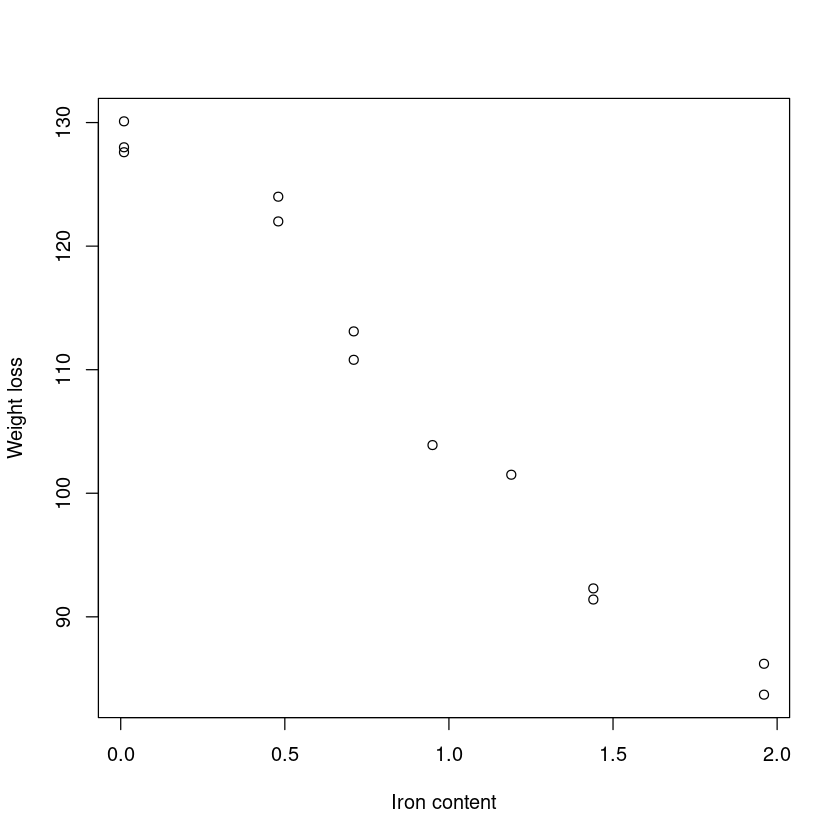

In [38]:
data(corrosion)
plot(loss ~ Fe, data = corrosion, xlab = "Iron content", ylab = "Weight loss")

In [39]:
# fitting a strainght line model
g = lm(loss ~ Fe, data = corrosion)
summary(g)


Call:
lm(formula = loss ~ Fe, data = corrosion)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7980 -1.9464  0.2971  0.9924  5.7429 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  129.787      1.403   92.52  < 2e-16 ***
Fe           -24.020      1.280  -18.77 1.06e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.058 on 11 degrees of freedom
Multiple R-squared:  0.9697,	Adjusted R-squared:  0.967 
F-statistic: 352.3 on 1 and 11 DF,  p-value: 1.055e-09


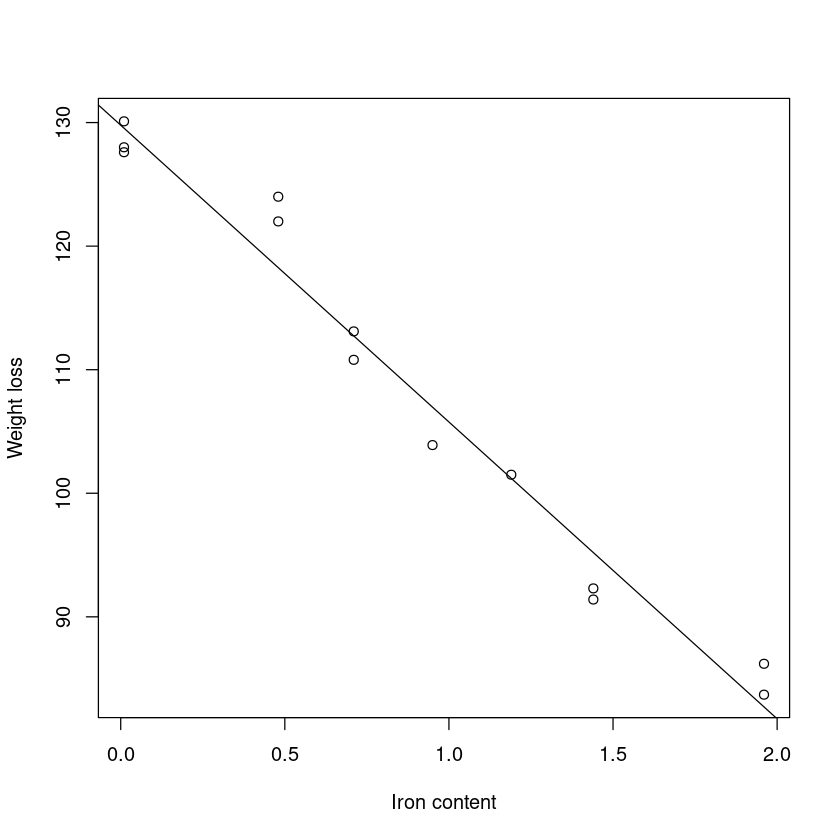

In [40]:
plot(loss ~ Fe, data = corrosion, xlab = "Iron content", ylab = "Weight loss")
abline(coef(g))


* Now let's fit a model that reserves a parameter for ach group of data with the same value o x

In [46]:
ga = lm(loss ~ factor(Fe), data = corrosion)
summary(ga)


Call:
lm(formula = loss ~ factor(Fe), data = corrosion)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2500 -0.9667  0.0000  1.0000  1.5333 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     128.567      0.809 158.914 4.19e-12 ***
factor(Fe)0.48   -5.567      1.279  -4.352  0.00481 ** 
factor(Fe)0.71  -16.617      1.279 -12.990 1.28e-05 ***
factor(Fe)0.95  -24.667      1.618 -15.245 5.03e-06 ***
factor(Fe)1.19  -27.067      1.618 -16.728 2.91e-06 ***
factor(Fe)1.44  -36.717      1.279 -28.703 1.18e-07 ***
factor(Fe)1.96  -43.617      1.279 -34.097 4.24e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.401 on 6 degrees of freedom
Multiple R-squared:  0.9965,	Adjusted R-squared:  0.9931 
F-statistic: 287.3 on 6 and 6 DF,  p-value: 4.152e-07


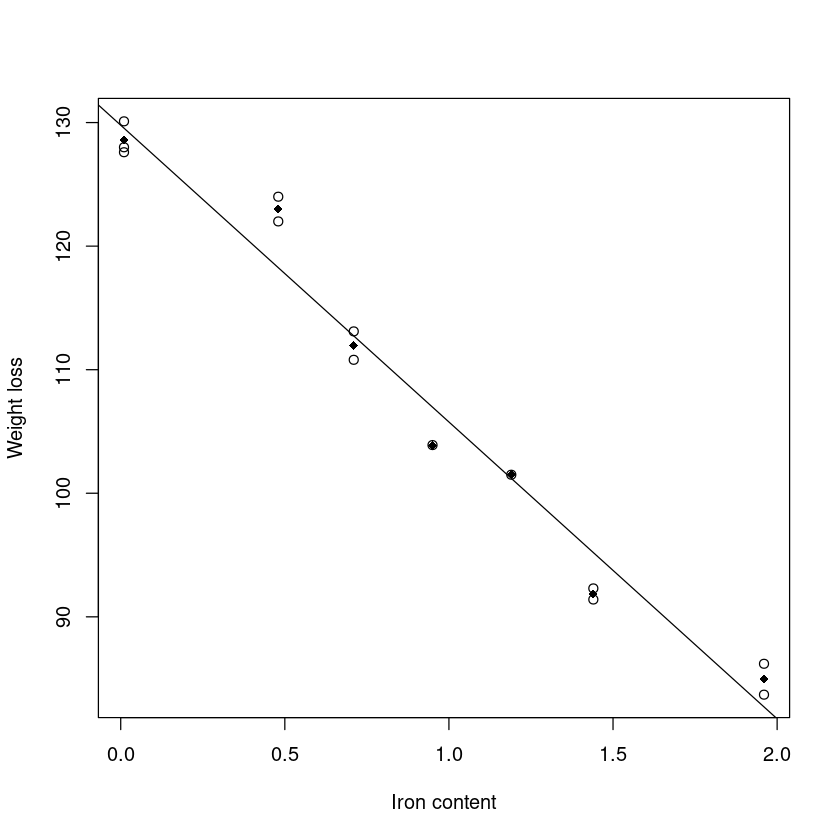

In [44]:
plot(loss ~ Fe, data = corrosion, xlab = "Iron content", ylab = "Weight loss")
abline(coef(g))
points(corrosion$Fe, fitted(ga), pch = 18)

In [45]:
# comparing the two models
anova(g, ga)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,11,102.85023,NA,NA,NA,NA
2,6,11.78167,5,91.06857,9.275621,0.008622834


* P-values indicates that there is a lack of fit. The reason is that $SD \sqrt{11.8/6}=1.4$ is substancially less than the regression standar error of 3.06

* Two hypotheses can explain the low pure error SD:
    
    
 1) Replicates are not genuine and the low pure error SD can be explained by some correlation in the
 
 2) There are a third variable lurking in that is causing the lack of fit
 
### How good a fit do we really want?

* Increasing the fit by increasing the number of parameter will also increase variance in any prediction

In [47]:
gp = lm(loss ~ Fe + I(Fe^2) + I(Fe^3) + I(Fe^4) + I(Fe^5) + I(Fe^6), data = corrosion)

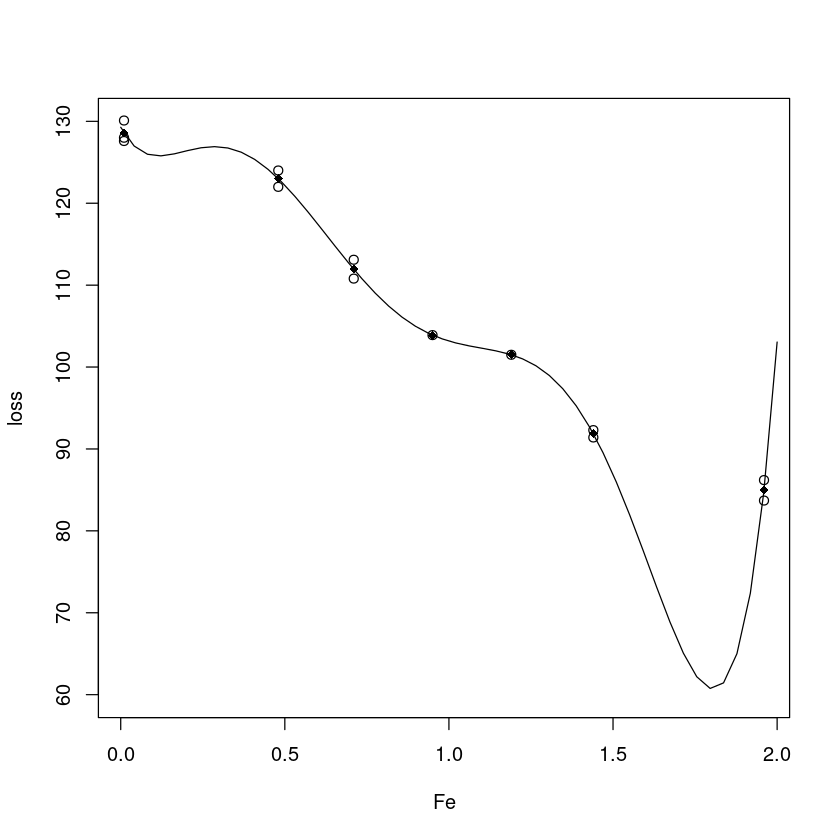

In [50]:
plot(loss ~Fe, data = corrosion, ylim = c(60, 130))
points(corrosion$Fe, fitted(ga), pch  =18)
grid  =  seq(0,2, len = 50)
lines(grid, predict(gp, data.frame(Fe=grid)))

In [54]:
round(summary(gp)$r.squared, 3)

[1] 0.997

* This model is obviously overfitted
* We should not focus too much on measures of fit such as $R^2$
* Fit should reflet knowledge and simplicity

### Robust Regression

* When the errors are normal, OLS regression is clearly best, but when they are not, then we should consider different approaches
* Of particular concern are the long-tailed error distributions
    - One solution might be remove the largest residual values (outliers)...  but that often has limited impact because of our limited capacity of evaluate multiple outliers

* One possible solution is the robust regression, which as several methods, but two will be shown

#### M-Estimation

We can estimate $\beta$ such as 

<p>&nbsp;</p>
\begin{split}
\sum_{i=1}^n \rho(y_i - x_i^T\beta)
\end{split}
<p>&nbsp;</p>

where
\begin{split}
\rho(x) =
\begin{cases}
 \frac{x^2}{2} \text{ if $x \leq c$} \\      
  cx - \frac{c^2}{2} \text{ otherwise}
\end{cases}
\end{split}

c should be a robust estimate of $\rho$. A value proportional to the median of $\hat \epsilon$ is suitable

with weights
<p>&nbsp;</p>
\begin{split}
\sum_{i=1}^n w_ix_{ij}(y_i - \sum_{i=1}^p x_{ij} \beta_j)=0, \:\: j=1, ...p
\end{split}
<p>&nbsp;</p>

Differentiating in respect to $\beta_j$ and setting everything to zero, we get

with weights

<p>&nbsp;</p>
\begin{split}
\sum_{i=1}^n p'(y_i - \sum_{i=1}^p x_{ij} \beta_j) x_{ij} =0 \:\: j=1, ...p
\end{split}
<p>&nbsp;</p>

Huber:
\begin{split}
w(u)=
\begin{cases}
 \frac{x^2}{2} \text{ if $x \leq c$} \\      
  cx - \frac{c^2}{2} \text{ otherwise}
\end{cases}
\end{split}


In [3]:
data(gala)
gl = lm(Species ~ Area + Elevation + Nearest + Scruz + Adjacent, data = gala)
summary(gl)


Call:
lm(formula = Species ~ Area + Elevation + Nearest + Scruz + Adjacent, 
    data = gala)

Residuals:
     Min       1Q   Median       3Q      Max 
-111.679  -34.898   -7.862   33.460  182.584 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.068221  19.154198   0.369 0.715351    
Area        -0.023938   0.022422  -1.068 0.296318    
Elevation    0.319465   0.053663   5.953 3.82e-06 ***
Nearest      0.009144   1.054136   0.009 0.993151    
Scruz       -0.240524   0.215402  -1.117 0.275208    
Adjacent    -0.074805   0.017700  -4.226 0.000297 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 60.98 on 24 degrees of freedom
Multiple R-squared:  0.7658,	Adjusted R-squared:  0.7171 
F-statistic:  15.7 on 5 and 24 DF,  p-value: 6.838e-07


In [5]:
#let's perform robust regression using rlm function from MASS
library(MASS)
gr = rlm(Species ~ Area + Elevation + Nearest + Scruz + Adjacent, data = gala)
summary(gr)


Call: rlm(formula = Species ~ Area + Elevation + Nearest + Scruz + 
    Adjacent, data = gala)
Residuals:
    Min      1Q  Median      3Q     Max 
-74.389 -18.353  -6.364  21.187 229.082 

Coefficients:
            Value   Std. Error t value
(Intercept)  6.3611 12.3897     0.5134
Area        -0.0061  0.0145    -0.4214
Elevation    0.2476  0.0347     7.1320
Nearest      0.3592  0.6819     0.5267
Scruz       -0.1952  0.1393    -1.4013
Adjacent    -0.0546  0.0114    -4.7648

Residual standard error: 29.73 on 24 degrees of freedom

* Because p-values are not given, we can use asymptotic normality of the estimator to make approximate inferences using the t-values. 

In [6]:
# LAD regression using quantreg package
library(quantreg)

Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve




In [7]:
attach(gala)
gq = rq(Species ~ Area + Elevation + Nearest + Scruz + Adjacent)
summary(gq)
detach(gala)


Call: rq(formula = Species ~ Area + Elevation + Nearest + Scruz + Adjacent)

tau: [1] 0.5

Coefficients:
            coefficients lower bd  upper bd 
(Intercept)   1.31445    -19.87777  24.37411
Area         -0.00306     -0.03185   0.52800
Elevation     0.23211      0.12453   0.50196
Nearest       0.16366     -3.16339   2.98896
Scruz        -0.12314     -0.47987   0.13476
Adjacent     -0.05185     -0.10458   0.01739

#### Least Trimmed Squares

Another popular method is least trimmed squares (LTS)
* This method has high breakdown point beacuse it can tolerate a large number of outliers depending on how q is chosen
* LTS is an example of *resistance* regression method

In [13]:
library(lqs)

ERROR: Error in library(lqs): there is no package called ‘lqs’
